# **Project 1**
This project aiming to build a residual network to achieve higher accuracy on the CIFAR-10 dataset.

In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from PIL import Image

### **Load Data**
Random horizontal flipping, random clipping, and normalization of data using transform. Then define the train and test loader.

In [2]:
# 解码 CIFAR-10 批量数据的函数
def load_cifar_train_and_val(file_path):
    """ 读取 CIFAR-10 的 .pkl 训练批次文件 """
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    
    # 解析数据
    data = batch[b'data']  # 图片数据
    labels = batch[b'labels']  # 标签
    data = data.reshape(-1, 3, 32, 32).astype(np.uint8)  # 调整形状 (N, C, H, W)
    
    return data, labels

In [3]:
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, data_dir, train=True, transform=None, include_test_batch=False):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        if train:
            # 加载 data_batch_* 文件
            for i in range(1, 6):  # data_batch_1 到 data_batch_5
                file_path = os.path.join(data_dir, f"data_batch_{i}")
                batch_data, batch_labels = load_cifar_train_and_val(file_path)
                self.data.append(batch_data)
                self.labels.extend(batch_labels)

            # 如果需要将 test_batch 并入训练集
            if include_test_batch:
                file_path = os.path.join(data_dir, "test_batch")
                batch_data, batch_labels = load_cifar_train_and_val(file_path)
                self.data.append(batch_data)
                self.labels.extend(batch_labels)
                
        else:
            # 仅加载 test_batch 作为验证集
            file_path = os.path.join(data_dir, "test_batch")
            batch_data, batch_labels = load_cifar_train_and_val(file_path)
            self.data.append(batch_data)
            self.labels.extend(batch_labels)
        
        # 合并所有批次的数据
        self.data = np.concatenate(self.data, axis=0)  # (N, 3, 32, 32)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]  # 获取图片
        label = self.labels[index]  # 获取标签
        
        # 先转换成 PIL Image，再应用 transform
        img = Image.fromarray(img.transpose(1, 2, 0))  # 转换为 (H, W, C) 
        # 转换成 PIL Image 并进行预处理
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [4]:
# 定义数据增强和归一化
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomCrop(32, padding=4),  # 随机裁剪
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 颜色抖动
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 指定数据路径
data_dir = "data/cifar-10-batches-py_train_and_val"

# 加载完整训练集(包括data_batch和test_batch)，后面使用K-fold交叉验证
# train_dataset = CustomCIFAR10Dataset(data_dir=data_dir, train=True, transform=transform)
# test_dataset = CustomCIFAR10Dataset(data_dir=data_dir, train=False, transform=transform)
full_train_dataset = CustomCIFAR10Dataset(data_dir=data_dir, train=True, transform=transform, include_test_batch=True)
print(f"数据加载完成！训练集大小: {len(full_train_dataset)}")

# # 创建 DataLoader
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
# print(f"数据加载完成！训练集大小: {len(train_dataset)}, 验证集大小: {len(test_dataset)}")

数据加载完成！训练集大小: 60000


In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Using device: {device}')

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # 这些值是CIFAR-10数据集RGB三个通道的均值和标准差,不需要改动
# ])

# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# compressed_file = './data/cifar-10-python.tar.gz'  # CIFAR-10 压缩包删除
# if os.path.exists(compressed_file):
#     os.remove(compressed_file)

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

### **Define basic residual block**
The constructure of each block is: conv + batch norm + ReLU + conv + batch norm. The output of the second convolution layer is added to the input of this block and passed through a ReLU activation function. Then the output will go to the next residual block.

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.3)  # 加入 Dropout，在每个mini-batch上随机丢弃部分神经元
        self.downsample = downsample

    # define the forward method for each block
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### **Define the model**
Next, we build the entire ResNet. It consists of an initial convolution layer, four residual block layers, a global averaging pooling layer and a fully connected layer. Finally, we define the method by which the input propagates forward throughout the network, as shown in the code:

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # 移除这一层

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)  # 这里也要改成 256，不然维度对不上

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    # define forward for the whole net
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

### **Instantiate the model, train and test**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# 定义 K 折交叉验证
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# # **初始化统计全局的 loss 和 accuracy 变量**
# loss_history = []
# accuracy_history = []

# **训练函数**
def train(epoch, train_loader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            avg_loss = running_loss / 200
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}')
            # loss_history.append(avg_loss)  # **存储 loss**
            running_loss = 0.0  # **重置 loss 计数**

# **验证函数**
def valid(val_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    # accuracy_history.append(accuracy)  # **存储 accuracy**
    return accuracy

# 假设每个 fold 完成后，保存每个 fold 的最佳模型
fold_models = []

# 交叉验证训练过程
for fold, (train_idx, val_idx) in enumerate(kf.split(full_train_dataset)):
    print(f"Fold {fold + 1}")

    # 划分训练集和验证集
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=128, sampler=train_sampler, num_workers=2)
    val_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=128, sampler=val_sampler, num_workers=2)
    
    # **修改 ResNet，减少深度**
    model = ResNet(ResidualBlock, [1, 1, 1]).to(device)  # 或者 [1, 1, 1, 1]，取决于你的实验需求

    criterion = nn.CrossEntropyLoss()

    # **选择优化器**
    optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-4)  # 调低学习率防止震荡
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4) #加入L2正则化项

    # **加入学习率衰减**
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5) # 学习率在100轮内平滑下降


    # **修改训练轮数 + 加入学习率调整**
    best_acc = 0.0
    for epoch in range(100):
        train(epoch, train_loader, model, criterion, optimizer)
        val_acc = valid(val_loader, model)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict()
        scheduler.step()  
    
    # 保存每个 fold 的最优模型权重为文件
    fold_model_filename = f"model/fold_{fold + 1}_best_model.pth"
    torch.save(best_model_state, fold_model_filename)  # 保存为文件
    fold_models.append(best_model_state)  # 保存每个 fold 的最优模型   

# # **绘制 loss 和 accuracy 曲线**
# plt.figure(figsize=(12,5))

# # **绘制 Loss 曲线**
# plt.subplot(1,2,1)
# plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Curve')

# # **绘制 Accuracy 曲线**
# plt.subplot(1,2,2)
# plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-', color='r')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.title('Test Accuracy Curve')

# plt.tight_layout()
# plt.show()

Using device: cuda
Fold 1
Epoch 1, Batch 200, Loss: 1.693
Validation Accuracy: 44.68%
Epoch 2, Batch 200, Loss: 1.124
Validation Accuracy: 56.50%
Epoch 3, Batch 200, Loss: 0.940
Validation Accuracy: 64.78%
Epoch 4, Batch 200, Loss: 0.826
Validation Accuracy: 71.28%
Epoch 5, Batch 200, Loss: 0.736
Validation Accuracy: 69.61%
Epoch 6, Batch 200, Loss: 0.649
Validation Accuracy: 75.56%
Epoch 7, Batch 200, Loss: 0.590
Validation Accuracy: 71.27%
Epoch 8, Batch 200, Loss: 0.534
Validation Accuracy: 80.42%
Epoch 9, Batch 200, Loss: 0.502
Validation Accuracy: 80.58%
Epoch 10, Batch 200, Loss: 0.462
Validation Accuracy: 79.53%
Epoch 11, Batch 200, Loss: 0.448
Validation Accuracy: 83.06%
Epoch 12, Batch 200, Loss: 0.417
Validation Accuracy: 83.10%
Epoch 13, Batch 200, Loss: 0.399
Validation Accuracy: 83.99%
Epoch 14, Batch 200, Loss: 0.370
Validation Accuracy: 85.18%
Epoch 15, Batch 200, Loss: 0.367
Validation Accuracy: 84.39%
Epoch 16, Batch 200, Loss: 0.346
Validation Accuracy: 83.52%
Epoch 1

### **Output model parameters and save weights**

In [11]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ✅ **1. 加载 Kaggle 提供的 `cifar_test_nolabel.pkl`**
# with open("/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl", "rb") as f:
#     cifar_test = pickle.load(f, encoding="bytes")

# test_images = cifar_test[b"data"]  # 读取数据
# test_images = test_images.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0  # (N, C, H, W)

# # ✅ **2. 创建 PyTorch 数据集**
# class CifarTestDataset(Dataset):
#     def __init__(self, images, transform=None):
#         self.images = images
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img = self.images[idx]  # (3, 32, 32)
        
#         if self.transform:
#             img = torch.tensor(img)  # 确保是 PyTorch Tensor
#             img = self.transform(img)  # 进行变换
#         return img  # **这里只返回图像**

# # ✅ **3. 定义 Transform**
# transform_test = transforms.Compose([
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 只做归一化
# ])

# # ✅ **4. 创建 DataLoader**
# test_dataset = CifarTestDataset(test_images, transform=transform_test)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# print(f"✅ Kaggle 测试集已加载，样本数：{len(test_dataset)}")


In [10]:
def load_cifar_test(file_path):
    """加载没有标签的 CIFAR-10 测试数据"""
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')  # 加载数据

    # 假设数据格式和训练集一样 (10000, 3072)
    images = data[b'data'].astype(np.uint8)  # shape (10000, 32, 32, 3)
    images = images.transpose(0, 3, 1, 2) # 从tensorflow形状变成torch形状(10000, 3, 32, 32)
    return images

In [11]:
class CustomCIFAR10TestDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data  # CIFAR 图像数据
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]  # (3, 32, 32)
        img = Image.fromarray(img.transpose(1, 2, 0))  # 转换为 PIL 格式 (H, W, C)

        if self.transform:
            img = self.transform(img)

        return img, index  # 返回图像和索引（ID）

In [12]:
# 数据预处理
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 的均值和标准差
])

# 加载没有标签的测试数据
test_data = load_cifar_test("data/cifar-10-batches-py_test/cifar_test_nolabel.pkl")

test_dataset = CustomCIFAR10TestDataset(test_data, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"测试集加载完成，样本数量: {len(test_dataset)}")
print("Shape of images:", test_data.shape)

测试集加载完成，样本数量: 10000
Shape of images: (10000, 3, 32, 32)


In [14]:
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载 5 个 fold 的模型
num_folds = 5
models = []
for fold in range(1, num_folds + 1):
    model = ResNet(ResidualBlock, [1, 1, 1]).to(device)  # 确保 ResNet 结构匹配
    model.load_state_dict(torch.load(f"model/fold_{fold}_best_model.pth"))  # 加载权重
    model.eval()  # 设为评估模式
    models.append(model)

# 测试集预测并生成csv
predictions = []

with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        # 存储所有模型的预测概率
        fold_probs = []
        for model in models:
            outputs = model(images)  # [batch_size, num_classes]
            probs = F.softmax(outputs, dim=1)  # 转换为概率分布
            fold_probs.append(probs)
            
        # 对 5 个模型的概率进行平均
        avg_probs = torch.stack(fold_probs).mean(dim=0)
        # 取最大概率对应的类别
        predicted_labels = torch.argmax(avg_probs, dim=1)
        # 存储 ID 和类别
        for img_id, label in zip(image_ids, predicted_labels.cpu().numpy()):
            predictions.append((img_id.item(), label))

# 生成提交用的 CSV 文件
submission_df = pd.DataFrame(predictions, columns=["ID", "Labels"])
submission_df = submission_df.sort_values("ID")  # 确保 ID 顺序正确
submission_df.to_csv("submission.csv", index=False)
print("The csv file has been generated.")

The csv file has been generated.


In [21]:
# # 均值和标准差
# mean = (0.4914, 0.4822, 0.4465)
# std = (0.2023, 0.1994, 0.2010)

# # 反归一化
# def denormalize(tensor):
#     for i in range(3):
#         tensor[i] = tensor[i] * std[i] + mean[i]
#     return tensor

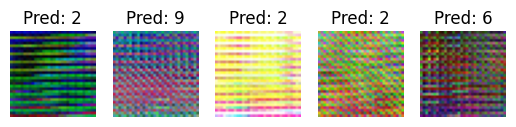

In [23]:
# # 对验证集的预测结果进行可视化
# import matplotlib.pyplot as plt

# # 读取 submission.csv 文件
# submission_df = pd.read_csv('submission.csv')

# # 从文件中提取出图像 ID 和标签
# image_ids = submission_df['ID'].values
# predicted_labels = submission_df['Labels'].values

# data_iter = iter(test_loader)
# # 获取测试集的所有图像和 ID
# all_images, all_image_ids = next(data_iter)

# num_samples = 5  # 显示的样本数量
# for i in range(num_samples):
#     img_id = image_ids[i]
#     label = predicted_labels[i]
    
#     # 找到对应的图像
#     img_idx = np.where(all_image_ids.numpy() == img_id)[0][0]
#     image = all_images[img_idx].cpu().clone()  # 复制一个图像，以便反归一化
#     image = denormalize(image)  # 反归一化图像
#     image = image.numpy().transpose((1, 2, 0))  # 转换为 [H, W, C] 格式
#     image = np.clip(image, 0, 1)
    
#     # 显示图像及其预测标签
#     plt.subplot(1, num_samples, i + 1)
#     plt.imshow(image)
#     plt.title(f"Pred: {label}")  # 显示标签（数字）
#     plt.axis('off')
# plt.show()